In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.fft import dct, idct

import sys
sys.path.append('../notebooks/')
from helpers import title

In [2]:
_VOLPIANO_TO_MIDI = {
    "8": 53, # F
    "9": 55, # G
    "a": 57,
    "y": 58, # B flat
    "b": 59,
    "c": 60,
    "d": 62,
    "w": 63, # E flat
    "e": 64,
    "f": 65,
    "g": 67,
    "h": 69,
    "i": 70, # B flat
    "j": 71,
    "k": 72, # C
    "l": 74,
    "x": 75, # E flat
    "m": 76,
    "n": 77,
    "o": 79,
    "p": 81,
    "z": 82, # B flat
    "q": 83, # B
    "r": 84, # C
    "s": 86,
    
    # Liquescents
    "(": 53,
    ")": 55,
    "A": 57,
    "B": 59,
    "C": 60,
    "D": 62,
    "E": 64,
    "F": 65,
    "G": 67,
    "H": 69,
    "J": 71,
    "K": 72, # C
    "L": 74,
    "M": 76,
    "N": 77,
    "O": 79,
    "P": 81,
    "Q": 83,
    "R": 84, # C
    "S": 86, # D
    
    # Naturals
    "Y": 59, # Natural at B
    "W": 64, # Natural at E
    "I": 71, # Natural at B
    "X": 76, # Natural at E
    "Z": 83,
}

def volpiano_to_midi(volpiano, fill_na=False, skip_accidentals=False):
    """
    Translates volpiano pitches to a list of midi pitches

    All non-note characters are ignored or filled with `None`, if `fill_na=True`
    Unless `skip_accidentals=True`, accidentals are converted to midi pitches
    as well. So an i (flat at the B) becomes 70, a B flat. Or a W (a natural at
    the E) becomes 64 (E).
    """
    accidentals = 'iwxyz' + 'IWXYZ'
    midi = []
    for char in volpiano:
        if skip_accidentals and char in accidentals:
            pass
        elif char in _VOLPIANO_TO_MIDI:
            midi.append(_VOLPIANO_TO_MIDI[char])
        elif fill_na:
            midi.append(None)
    return midi

In [3]:
def volpiano_to_contour(volpiano, num_samples=50):
    pitches = volpiano_to_midi(volpiano + volpiano[-1])
    xs = np.linspace(0, 1, len(pitches))
    func = scipy.interpolate.interp1d(xs, pitches, kind='previous')
    return func(np.linspace(0, 1, num_samples))

In [4]:
def get_contours(df, chants, segmentation, N=1000):
    all_units = [unit for chant in df[segmentation].str.split() for unit in chant]
    all_units = np.asarray(all_units)
    lengths = np.asarray([len(unit) for unit in all_units])
    
    unit_counts = df[segmentation].str.split().map(len)
    modes = [[mode]*count for mode, count in zip(chants['mode'], unit_counts)]
    modes = np.array([mode for chant in modes for mode in chant])
    assert len(all_units) == len(modes)
    
    units_per_length = {}
    modes_per_length = {}
    for l in np.unique(lengths):
        units_per_length[l] = all_units[lengths == l]
        modes_per_length[l] = modes[lengths == l]
        
    contours = {}
    for l, units in units_per_length.items():
        c = [volpiano_to_contour(u) for u in units[:N]]
        contours[l] = np.asarray(c)
        
    cos_contours = { l: dct(cont) for l, cont in contours.items() }
    
    return cos_contours, contours, units_per_length, modes_per_length

In [5]:
data_dir = '../../ISMIR2020/data/run-0/responsory/full'
chants = pd.read_csv(f'{data_dir}/train-chants.csv', index_col=0)
df = pd.read_csv(f'{data_dir}/train-representation-pitch.csv', index_col=0)

In [6]:
contours = {}
for segmentation in ['neumes', 'syllables', 'words', '4-mer', '6-mer', '8-mer']:
    cos_cont, cont, units, modes = get_contours(df, chants, segmentation)
    contours[segmentation] = dict(
        cos_contours=cos_cont, 
        contours=cont, 
        units=units,
        modes=modes)

In [7]:
contours['syllables']['modes'][2]

array([8, 8, 8, ..., 7, 7, 7])

In [8]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from scipy.spatial import distance_matrix

Text(0.5, 1.07, 'Length 2')

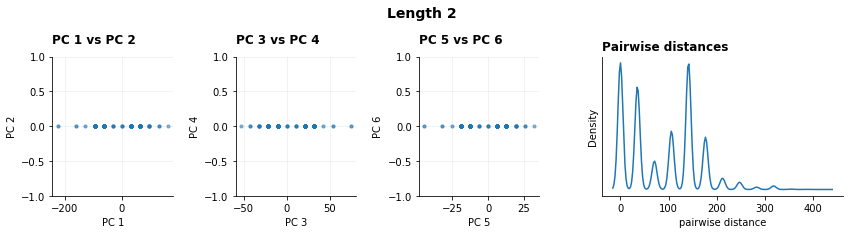

In [9]:
def show_pca_subplot(cont, comp1, comp2, ax):
    ax.plot(cont[:, comp1], cont[:, comp2], '.', alpha=.1)
    title(f'PC {comp1} vs PC {comp2}', ax=ax, y=1.05)
    ax.set_xlabel(f'PC {comp1}')
    ax.set_ylabel(f'PC {comp2}')
    sns.despine(ax=ax)
    ax.grid(True, alpha=.2)
    
    a, b = ax.get_ylim()
    if np.abs(a-b) < 10e-10:
        ax.set_ylim(-1, 1)
        
    a, b = ax.get_xlim()
    if np.abs(a-b) < 10e-10:
        ax.set_xlim(-1, 1)
        
def show_pd_plot(cont, ax):
    pm = pdist(cont[:, 1:])
    sns.kdeplot(pm, ax=ax)
    sns.despine(ax=ax)
    ax.set_yticks([])
    ax.set_xlabel('pairwise distance')
    title('Pairwise distances', ax=ax)

def show_pca(cont):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True,
                           gridspec_kw=dict(width_ratios=[1,1,1,2]))
    show_pca_subplot(cont, 1, 2, axs[0])
    show_pca_subplot(cont, 3, 4, axs[1])
    show_pca_subplot(cont, 5, 6, axs[2])
    show_pd_plot(cont, ax=axs[3])

show_pca(contours['syllables']['cos_contours'][2])
plt.suptitle('Length 2', y=1.07, fontsize=14, fontweight='bold')

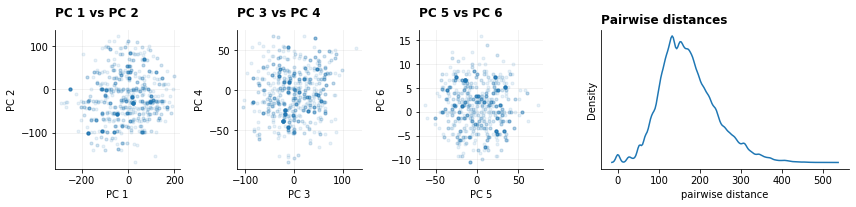

In [10]:
show_pca(contours['words']['cos_contours'][6])

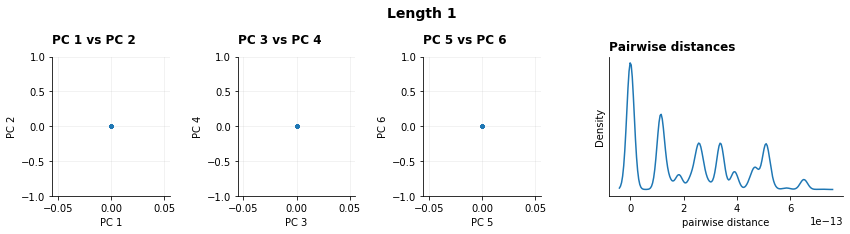

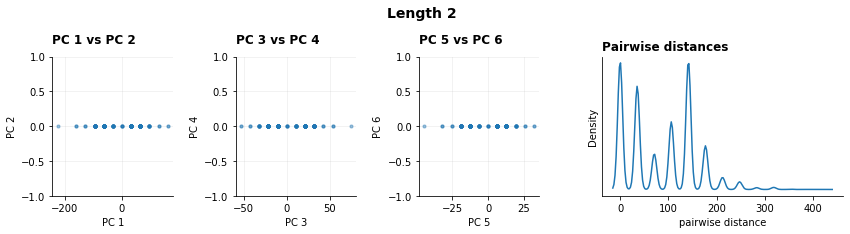

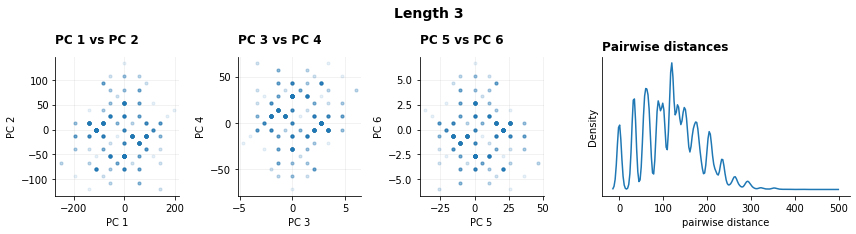

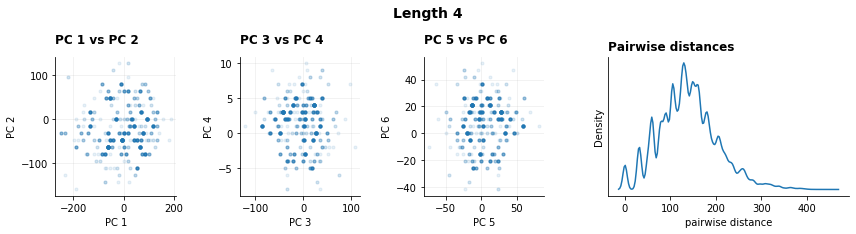

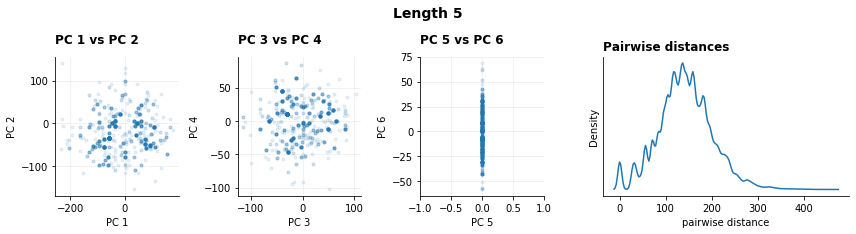

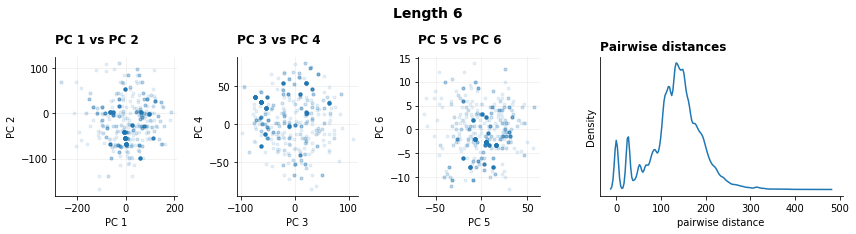

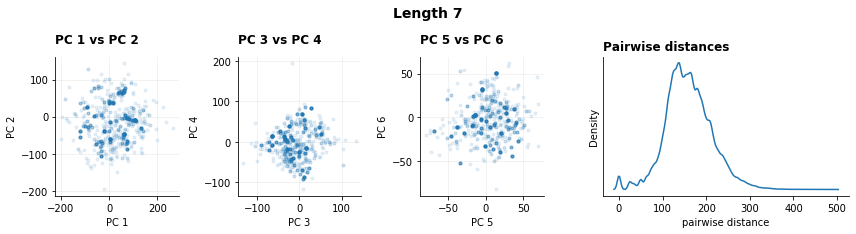

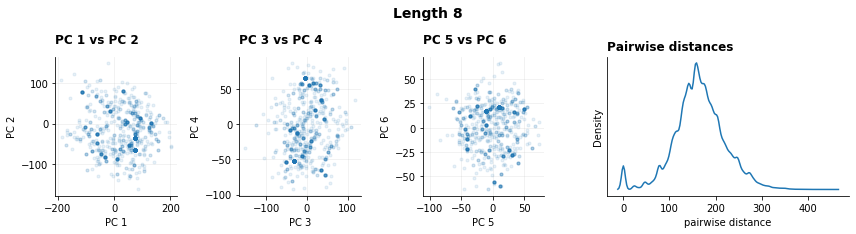

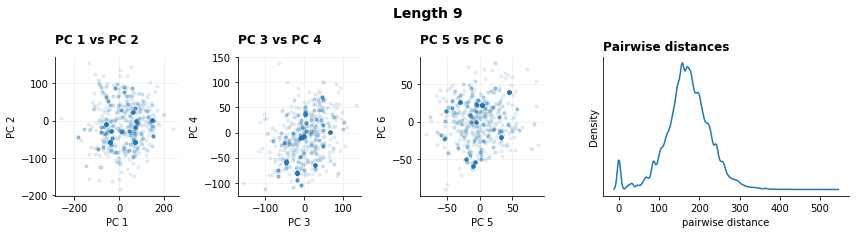

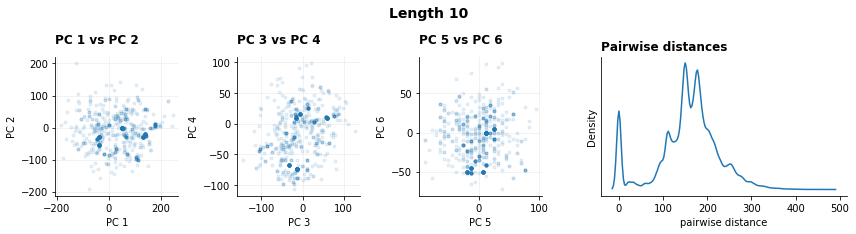

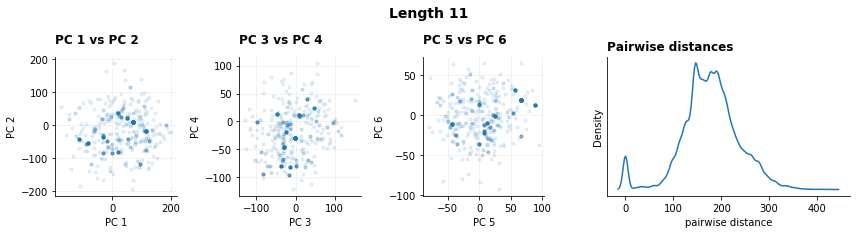

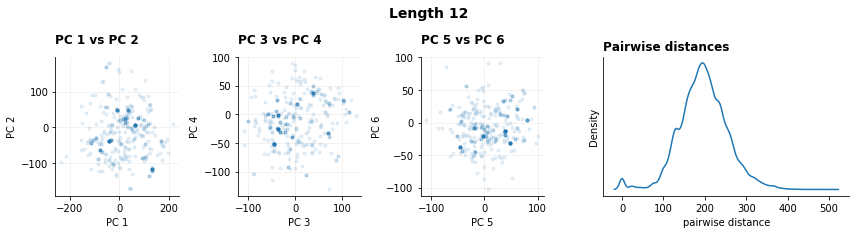

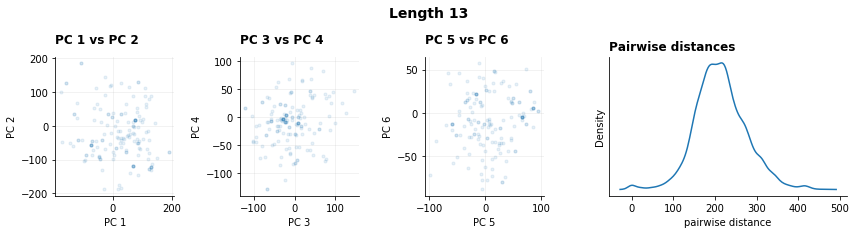

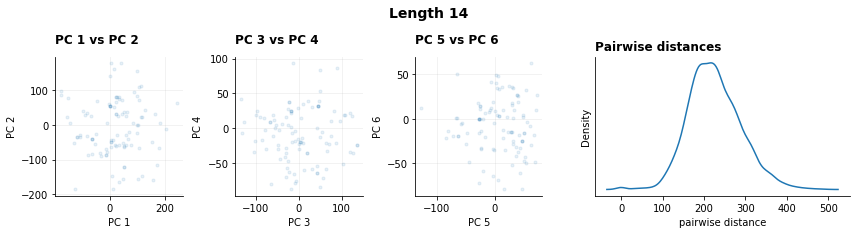

In [40]:
for l in range(1, 15):
    cont = contours['syllables']['cos_contours'][l]
    show_pca(cont)
    plt.suptitle(f'Length {l}', y=1.07, fontsize=14, fontweight='bold')

In [126]:
from unidip.dip import diptst as diptest

In [134]:
for l in range(1, 15):
    try:
        pm = pdist(cos_contours[l])
        dip, pval, (left_idx, right_idx) = diptest(np.msort(pm), is_hist=False, numt=100)
        print(f'length {l}: p = {pval:.5f}')
    except: 
        continue

length 1: p = 0.04950
length 2: p = 0.03960
length 8: p = 0.00990
length 10: p = 0.00990
length 11: p = 0.00990
length 12: p = 0.00990
length 13: p = 0.94059
length 14: p = 1.00000


In [30]:
import umap

In [15]:
refresh = False
for segm in ['syllables']:
    contours[segm]['umap'] = dict()
#     contours[segm]['densmap'] = dict()
    for l in range(2, 15):
        cont = contours[segm]['cos_contours'][l][:, 1:]
        try:
            if l not in contours[segm]['umap'] or refresh: 
                umap_emb = umap.UMAP().fit(cont)
                contours[segm]['umap'][l] = umap_emb
        
#             if l not in contours[segm]['densmap'] or refresh: 
#                 densmap_emb = umap.UMAP(densmap=True).fit(cont)
#                 contours[segm]['densmap'][l] = densmap_emb
        except:
            continue

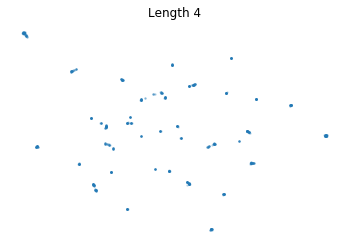

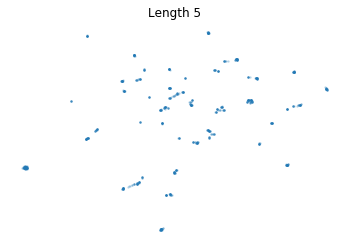

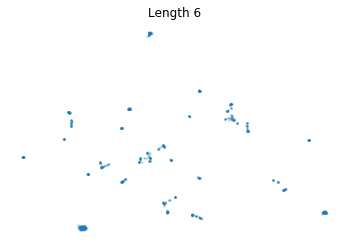

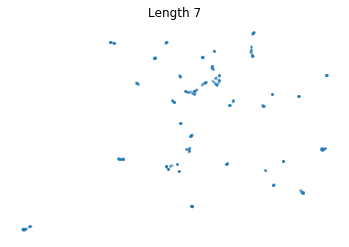

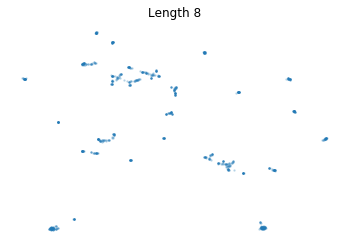

In [13]:
for l in range(4, 9):
    plt.figure()
    emb = contours['syllables']['umap'][l].embedding_
    plt.plot(emb[:, 0], emb[:, 1], '.', alpha=.2, ms=3)
    plt.title(f'Length {l}')
    plt.axis('off')

In [14]:
from matplotlib import cm

In [43]:
def inverse(mapper, points):
    inv_points = mapper.inverse_transform(points)
    return idct(np.c_[np.ones(len(points)), inv_points])

In [90]:
x_coords = np.linspace(-20, 30, 20)
points = np.c_[x_coords, np.ones(len(x_coords))*15]

mapper = contours['syllables']['umap'][6]
emb = mapper.embedding_
origs = inverse(mapper, points)

In [36]:
from sklearn.cluster import KMeans, DBSCAN

In [37]:
def group_by(X, labels):
    grouped = dict()
    unique_labels = np.sort(np.unique(labels))
    for label in unique_labels:
        grouped[label] = X[labels == label]
    return grouped

(2,)
(2,)
(2,)
(2,)
(2,)
(51,)
(51,)
(51,)
(51,)
(51,)


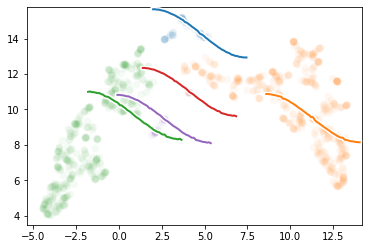

In [77]:
def show_clustered_embedding(mapper, clustering, w=6, h=3, ax=None, ylim=(-4, 4)):
    grouped = group_by(mapper.embedding_, clustering.labels_)
    labels = list(grouped.keys())
    centers = {}
    for label, group in grouped.items():
        centers[label] = group[0, :]#.mean(axis=0)
#         print(centers[label].shape)
        
    centers_arr = np.array([centers[l] for l in labels])
    inv_centers = dict(zip(labels, inverse(mapper, centers_arr)))
    
    if ax is None: ax = plt.gca()
    for label, group in grouped.items():
        l, = plt.plot(group[:, 0], group[:, 1], '.', alpha=.05, ms=15, markeredgewidth=0)
        color = l.get_color()

        x, y = centers[label]
        inv_center = inv_centers[label]
        axins = ax.inset_axes([x - w/2, y-h/2, w, h], transform=ax.transData)
        axins.axis('off')
#         axins.set_ylim(*ylim)
        print(inv_center.shape)
        axins.plot(inv_center, color='w', lw=5)
        axins.plot(inv_center, color=color, lw=2)
        
# show_clustered_embedding(mapper, clustering)
show_clustered_embedding(mapper, clustering)

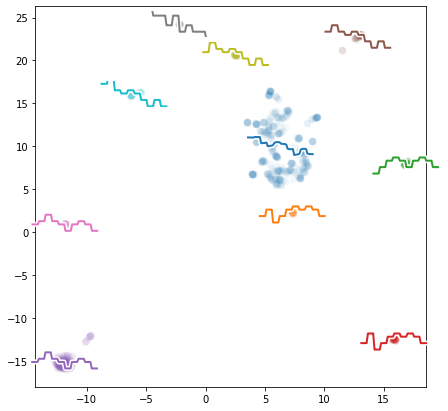

In [111]:
plt.figure(figsize=(7, 7))
clustering = DBSCAN(eps=2)
mapper = contours['syllables']['umap'][10]
emb = mapper.embedding_
clustering.fit(emb)
show_clustered_embedding(mapper, clustering)

In [ ]:
plt.figure(figsize=(7, 7))
clustering = DBSCAN(eps=1)
clustering.fit(emb)
show_clustered_embedding(mapper, clustering, h=3)

## Cluster the cosine contours directly

In [57]:
clustering = DBSCAN()
clustering.fit(contours['syllables']['contours'][6])

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

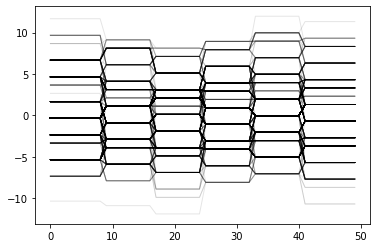

In [150]:
cont = contours['syllables']['contours'][6]
cont = cont - cont.mean(axis=0)[np.newaxis, :]
plt.plot(cont.T, 'k-', lw=1, alpha=.1);

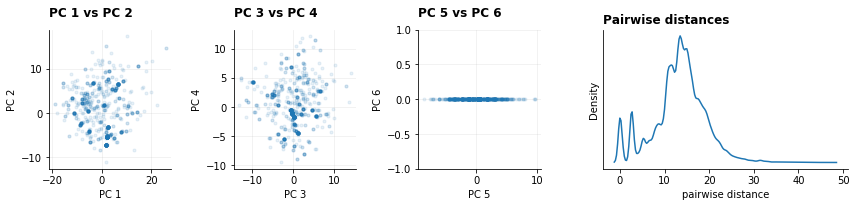

In [160]:
cont = contours['syllables']['contours'][6]
pca = PCA(n_components=10)
X = pca.fit_transform(cont)
show_pca(X)

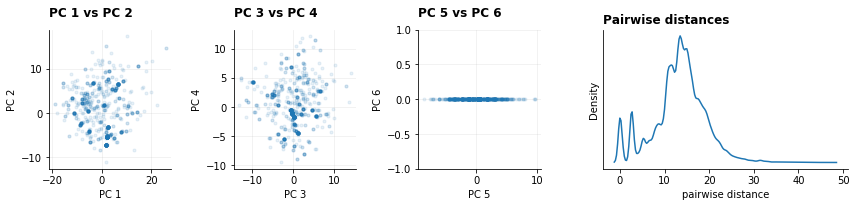

In [179]:
cont = contours['syllables']['contours'][6]
pca = PCA(n_components=10)
X = pca.fit_transform(cont)
show_pca(X)

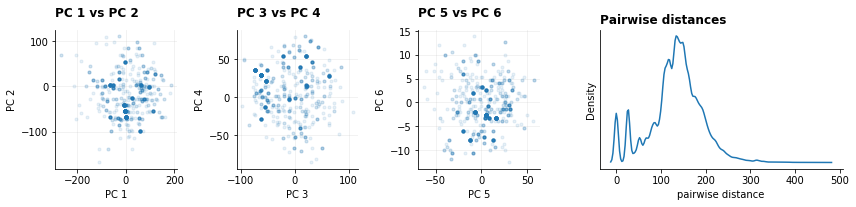

In [180]:
show_pca(contours['syllables']['cos_contours'][6])

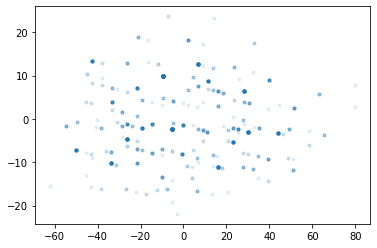

In [149]:
plt.plot(X[:, 0], X[:, 1], '.', alpha=.1)

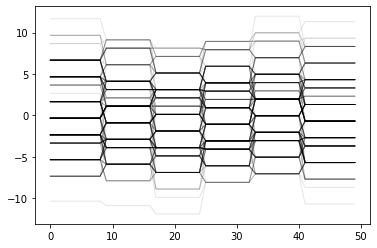

In [74]:
plt.plot(np.unique(cont, axis=0).T,  'k-', lw=1, alpha=.1);

In [62]:

contours['syllables']['contours'][6]

array([[65., 65., 65., ..., 69., 69., 69.],
       [72., 72., 72., ..., 71., 71., 71.],
       [67., 67., 67., ..., 69., 69., 69.],
       ...,
       [67., 67., 67., ..., 69., 69., 69.],
       [67., 67., 67., ..., 69., 69., 69.],
       [74., 74., 74., ..., 71., 71., 71.]])

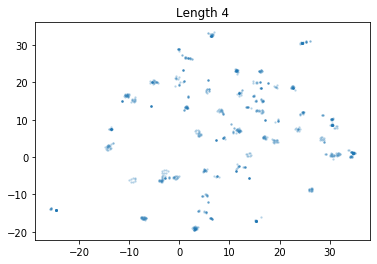

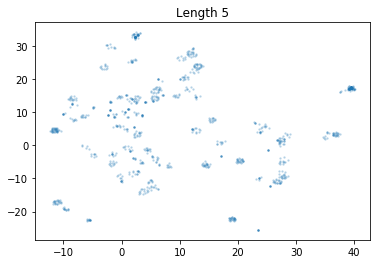

In [118]:
for l in range(4, 6):
    plt.figure()
    emb = contours['syllables']['densmap'][l].embedding_
    plt.plot(emb[:, 0], emb[:, 1], '.', alpha=.2, ms=3)
    plt.title(f'Length {l}')

In [11]:
import melodic_contour

In [17]:
H = melodic_contour.HuronTypology(tolerance=1)
for l in range(6,7):
    contour_types = np.asarray([
        H.classify(melodic_contour.Contour(c))
        for c in contours['syllables']['contours'][5]
    ])
    
    plt.figure()
    emb = contours['syllables']['umap'][l].embedding_
    for t in H.types:
        matches = contour_types == t
        plt.plot(emb[matches, 0], emb[matches, 1], '.', alpha=.5, ms=4, 
                label=t)
    plt.title(f'Length {l}')

KeyError: 6

<Figure size 432x288 with 0 Axes>

In [137]:
contour_types

['ascending-horizontal',
 'ascending',
 'ascending-horizontal',
 'ascending-horizontal',
 'horizontal',
 'horizontal',
 'ascending-horizontal',
 'horizontal',
 'ascending-horizontal',
 'convex',
 'horizontal',
 'ascending-horizontal',
 'horizontal-descending',
 'ascending-horizontal',
 'horizontal-descending',
 'convex',
 'ascending',
 'ascending-horizontal',
 'horizontal',
 'descending',
 'horizontal',
 'horizontal-ascending',
 'horizontal-descending',
 'ascending-horizontal',
 'ascending-horizontal',
 'ascending-horizontal',
 'ascending-horizontal',
 'horizontal',
 'concave',
 'ascending-horizontal',
 'horizontal',
 'horizontal',
 'horizontal',
 'horizontal',
 'descending',
 'ascending-horizontal',
 'ascending-horizontal',
 'ascending-horizontal',
 'horizontal',
 'ascending',
 'convex',
 'ascending-horizontal',
 'ascending-horizontal',
 'ascending-horizontal',
 'descending',
 'horizontal-descending',
 'descending-horizontal',
 'horizontal',
 'horizontal-descending',
 'ascending-horiz

In [122]:
hmelodic_contour

<module 'melodic_contour' from '/Users/bas/repos/projects/melodic-contour/melodic_contour/__init__.py'>

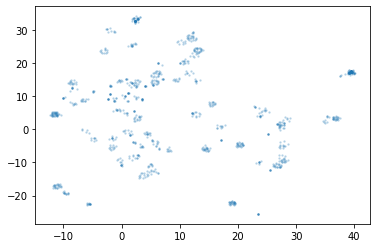

In [117]:
plt.plot(densmap.embedding_[:, 0], densmap.embedding_[:, 1], '.', alpha=.2, ms=3)

In [ ]:
contours['syllables']['densmap'].get

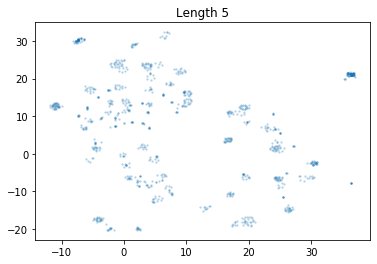

In [76]:
for l in range(5, 6):
    plt.figure()
    cont = contours['syllables']['cos_contours'][l]
    emb = umap.UMAP(densmap=True).fit_transform(cont)
    plt.plot(emb[:, 0], emb[:, 1], '.', alpha=.2, ms=3)
    plt.title(f'Length {l}')


In [83]:
emb = umap.UMAP().fit(cont)

In [88]:
orig = emb.inverse_transform([[0, 2]])
orig

array([[ 6.5596523e+03, -7.7218201e+01,  3.2030752e+00, -1.6261036e+01,
        -9.3583603e+00,  7.6646905e-16,  6.2427058e+00,  6.2659979e+00,
         2.1674263e-01,  7.8042164e+00,  1.1587091e-22, -6.2931824e+00,
        -7.3154330e-01, -3.0035455e+00, -2.7125533e+00,  8.7852843e-18,
         2.3867388e+00,  2.2314117e+00,  1.0673519e+00,  3.6054940e+00,
        -5.9688216e-14, -3.2954400e+00, -1.1850773e+00, -1.6783706e+00,
        -1.4544915e+00, -3.9442942e-16,  1.3175893e+00,  1.5140494e+00,
         1.2975154e+00,  2.5528839e+00, -4.3366040e-14, -2.4332938e+00,
        -1.2521696e+00, -1.3603343e+00, -9.4773161e-01,  5.8858027e-16,
         8.8579202e-01,  1.2998815e+00,  1.1708125e+00,  2.1237969e+00,
         3.7648750e-23, -2.0783246e+00, -1.1377213e+00, -1.2413467e+00,
        -7.3368835e-01, -7.1496579e-16,  7.1632212e-01,  1.2236599e+00,
         1.1135257e+00,  1.9918602e+00]], dtype=float32)

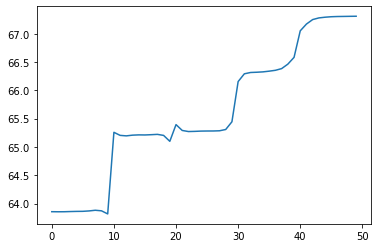

In [95]:
plt.plot(idct(orig).T)